In [1]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import requests
import json
import geopy
from geopy import distance
import datetime as d
import matplotlib.pylab as plb
from scipy import stats
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D

#API keys
import api_keys

C:\Users\jfoust\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


---

### General Process

1) Generate map of equally spaced coordinates in California to minimize search overlap  

    a)  Create arbitrary grid of coordinates using boundary latitude and longitude values that encompass California.  
        Each point is 25 miles and 60° from neighbor, creating hexagonal patter.  
    
    b)  Keep only the coordinates that are in California, determined through use of geocoding API
    
    
2)  Generate list of all locations in California using a specific search term

    a)  Using Yelp API, search at each coordinate generated in previous step
    
    b)  Clean up data: remove duplicates
    
    
3)  Prepare life expectancy US cencus data

    a)  Match cencus life expectancy data to zip codes using data file
    
    b)  Group by zip code and average life expectancies
    
    
4)  Count number of search results within specified distance of zip code associated with life expectancy

    a)  Loop through each Zip Code and match latitude and longitude values from data file
    
    b)  Calculate distance between zip code and every search result using coordinates, increment count by one in within specified range


5)  Regretion analysis of data
     

---

## Import Data

In [4]:
life_exp_data = pd.read_csv('imported_data/ca_life_exp.csv')   #Life expectancy by Zip Code
ca_search_coords = pd.read_csv('imported_data/ca_search_coords.csv')   #Coordinates within California in hexagonal pattern 25 miles away from all neighboring points
zip_tract = pd.read_csv('imported_data/tract_zip.csv')   #Zip Codes for US Census tracts
zip_coord = pd.read_csv('imported_data/zip_coord.csv')   #Coordinates of Zip Codes

---

## Generate Equidistant Search Coordinate Grid

In [6]:
#Longitude Range: -126 to -113.5
#Latitude Range: 42.5 to 32

ca_range_coords = [[-126,42.5]]   #Initial starting coordinate
search_radius = 25   #Spacing between coordinates

   #Create eastward line of coordinates between longitude range
while ca_range_coords[-1][0] < -113.5:
    origin = geopy.Point(ca_range_coords[-1][1], ca_range_coords[-1][0])
    coord_dist = geopy.distance.geodesic(miles=search_radius).destination(origin, 90)
    ca_range_coords.append([coord_dist[1],coord_dist[0]])
    
    #Create east-west lines of coordinates in southerly direction until latitude 32°
while ca_range_coords[-1][1] > 32:

        #Create single point southeast 60° to start next line
    origin = geopy.Point(ca_range_coords[-1][1], ca_range_coords[-1][0])
    coord_dist = geopy.distance.geodesic(miles=search_radius).destination(origin, 150)
    ca_range_coords.append([coord_dist[1],coord_dist[0]])
    
        #Create westward line of coordinates between longitude range
    while ca_range_coords[-1][0] >= -126:
        origin = geopy.Point(ca_range_coords[-1][1], ca_range_coords[-1][0])
        coord_dist = geopy.distance.geodesic(miles=search_radius).destination(origin, 270)
        ca_range_coords.append([coord_dist[1],coord_dist[0]])
    
        #Create single point southeast 60° to start next line
    origin = geopy.Point(ca_range_coords[-1][1], ca_range_coords[-1][0])
    coord_dist = geopy.distance.geodesic(miles=search_radius).destination(origin, 150)
    ca_range_coords.append([coord_dist[1],coord_dist[0]])
    
        #Create eastward line of coordinates between longitude range
    while ca_range_coords[-1][0] < -113.5:
        origin = geopy.Point(ca_range_coords[-1][1], ca_range_coords[-1][0])
        coord_dist = geopy.distance.geodesic(miles=search_radius).destination(origin, 90)
        ca_range_coords.append([coord_dist[1],coord_dist[0]])

In [7]:
#Create DataFrame

ca_range_coords = pd.DataFrame(ca_range_coords, columns=('Longitude','Latitude'))

In [ ]:
#If coordinate falls within California, determined by referencing API below, record that coordinate

base_url = 'http://geocode.arcgis.com/arcgis/rest/services/World/GeocodeServer/reverseGeocode'

ca_search_coords = []

for i in range(ca_range_coords.shape[0]):
    df_lat = ca_range_coords.loc[i,'Latitude']
    df_lon = ca_range_coords.loc[i,'Longitude']
    
    params = {
        'f': "pjson",
        'featureTypes': "",
        'location': "{0},{1}".format(df_lon,df_lat)
    }
    
    try:
        if requests.get(base_url, params=params).json()['address']['Region'] == 'California':
            ca_search_coords.append([df_lon,df_lat])
            print(ca_search_coords[-1])
    except:
        next
    
    print(i)
    
print(len(ca_search_coords))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
[-123.99574116436668, 41.812989278171464]
59
[-123.51154608940516, 41.81196882667569]
60
[-123.02735869903923, 41.810948411511276]
61
[-122.54317899259703, 41.809928032675785]
62
[-122.0590069694068, 41.80890769016678]
63
[-121.57484262879683, 41.80788738398181]
64
[-121.09068597009552, 41.80686711411845]
65
[-120.60653699263136, 41.80584688057424]
66
[-120.1223956957329, 41.80482668334677]
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
[-120.32884383276583, 41.46145350140994]
97
[-120.81041504190645, 41.46044549838973]
98
[-121.29197879433966, 41.459437530871945]
99
[-121.77353509070875, 41.458429598854224]
100
[-122.25508393165696, 41.45742170233424]
101
[-122.73662531782742, 41.45641384130964]
102
[-123.21815924986322, 41.45540601577808]
103
[-123.69968572840733, 41.4543982257

In [ ]:
ca_search_coords = pd.DataFrame(ca_search_coords, columns=('Longitude','Latitude'))

ca_search_coords.to_csv(path_or_buf='exported_data/ca_search_coords.csv', index=False)

In [5]:
with open('ca_boundaries_geojson.json', 'r') as j:
    json_data = json.load(j)
    
json_df = pd.DataFrame(json_data['geometries'][0]['coordinates'][0][0], columns=['Longitude','Latitude'])

In [6]:
ca_zips = zip_coord[(zip_coord['Zip'] <= 96100) & (zip_coord['Zip'] >= 90000)]

NameError: name 'ca_range_coords' is not defined

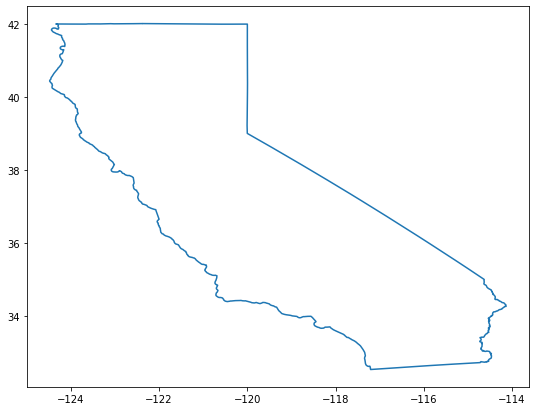

In [7]:
plt.figure(figsize=(9,7))

plt.plot(json_df['Longitude'],json_df['Latitude'])
plt.scatter(ca_range_coords['Longitude'],ca_range_coords['Latitude'],c='red',label='Initial Equidistant Coordinates')
plt.scatter(ca_search_coords['Longitude'],ca_search_coords['Latitude'], c='green',label='California Equidistant Coordinates')

plt.xlabel('Longitude (°)',weight='bold')
plt.ylabel('Latitude (°)',weight='bold')
plt.title('Equidistant Coordinate Map',size=20,weight='bold')

plt.legend()

plt.savefig('images/equidistant_coordinate_map.png')
plt.show()

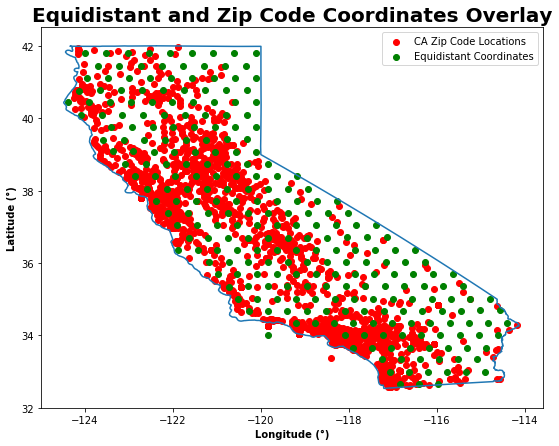

<Figure size 432x288 with 0 Axes>

In [11]:
plt.figure(figsize=(9,7))

plt.plot(json_df['Longitude'],json_df['Latitude'])
plt.scatter(ca_zips['Longitude'],ca_zips['Latitude'],c='red',label='CA Zip Code Locations')
plt.scatter(ca_search_coords['Longitude'],ca_search_coords['Latitude'], c='green',label='Equidistant Coordinates')

plt.xlabel('Longitude (°)',weight='bold')
plt.ylabel('Latitude (°)',weight='bold')
plt.title('Equidistant and Zip Code Coordinates Overlay',size=20,weight='bold')

plt.legend()

plt.savefig('images/ca_25mi_equidistant.png')
plt.show()

plt.savefig('overlay.png')

---

## Yelp Search

In [ ]:
#Yelp searchs are limited to 50 results per search and by default return 20 hits within a 25 mile radius

yelp_result = []

yelp_base_url = "https://api.yelp.com/v3/businesses/search"
headers = {
    'Authorization': "Bearer %s" % api_keys.yelp_key,
}

#--- Set search_term for Yelp search #---
                                     #---
search_term = 'museum'               #---
                                     #---
#--- Set search_term for Yelp search #---

for coord in range(ca_search_coords.shape[0]):   #Cycle through every CA search coordinate

    print(f'--- {coord + 1} ---\nlat: {ca_search_coords.loc[coord,"Latitude"]}\nlon: {ca_search_coords.loc[coord,"Longitude"]}')
    
    #   Initial hits and offset values ensure at least one search cycle will occur using a while loop
    hits = 50
    offset = -50
    
    while hits == 50:
        
        offset += hits
        print(f'ofset = {offset}')
        
        params = {
            'latitude': ca_search_coords.loc[coord,'Latitude'],
            'longitude': ca_search_coords.loc[coord,'Longitude'],
            #'location': "Los Angeles",
            'term': search_term,
            'offset': offset,
            'limit': 50
        }

        
        #print(requests.get(yelp_base_url, headers=headers, params=params).url)
        
        response = requests.get(yelp_base_url, headers=headers, params=params).json()
        
        try:
            for i in range(len(response['businesses'])):
                yelp_result.append(response['businesses'][i])
            hits = len(response['businesses'])
            print(f'results = {len(response["businesses"])}')
        except:
            break

    print(f'Total results: {len(yelp_result)}')

In [8]:
#   Put all search results in DataFrame and save to CSV file

yelp_result_list = []

for hit in range(len(yelp_result)):
    try:
        yelp_result_list.append \
        ([
            yelp_result[hit]['id'],   #ID
            yelp_result[hit]['name'],   #Name
            yelp_result[hit]['categories'][0]['alias'],   #Category search alias
            yelp_result[hit]['categories'][0]['title'],   #Category title
            yelp_result[hit]['coordinates']['latitude'],   #Latitude
            yelp_result[hit]['coordinates']['longitude'],   #Longitude
            yelp_result[hit]['location']['address1'],   #Address
            yelp_result[hit]['location']['city'],   #City
            yelp_result[hit]['location']['state'],   #State
            int(yelp_result[hit]['location']['zip_code']),   #Zip code
        ])
    except:
        next
        
yelp_result_df = pd.DataFrame \
(
    yelp_result_list,
    columns = \
    [
        'ID',
        'Name',
        'Search Alias',
        'Category',
        'Latitude',
        'Longitude',
        'Address',
        'City',
        'State',
        'Zip Code'
    ]
)

results_file_path = 'exported_data/yelp_search_results_' + d.datetime.today().strftime("%Y-%m-%d-%H%M%S") + '.csv'

yelp_result_df.to_csv(results_file_path)

---

## Search Results Data Cleanup

In [9]:
#Number of duplicate rows due to overlap in search radius

yelp_result_df.duplicated().sum()

3686

In [10]:
#Remove rows that are exact duplicates

yelp_result_df = yelp_result_df.drop_duplicates()

In [11]:
#Keep only results in California
#search_result = yelp_result_df[yelp_result_df['State'] == 'CA']

#Keep all results
search_result = yelp_result_df

In [12]:
search_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2226 entries, 0 to 5908
Data columns (total 10 columns):
ID              2226 non-null object
Name            2226 non-null object
Search Alias    2226 non-null object
Category        2226 non-null object
Latitude        2226 non-null float64
Longitude       2226 non-null float64
Address         2199 non-null object
City            2226 non-null object
State           2226 non-null object
Zip Code        2226 non-null int64
dtypes: float64(2), int64(1), object(7)
memory usage: 191.3+ KB


---

## Life Expectancy Data Cleanup

In [13]:
life_exp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7516 entries, 0 to 7515
Data columns (total 5 columns):
Unnamed: 0    7516 non-null int64
Tract ID      7516 non-null int64
e(0)          7516 non-null float64
se(e(0))      7516 non-null float64
Zip Code      7516 non-null int64
dtypes: float64(2), int64(3)
memory usage: 293.7 KB


In [14]:
#Remove extraneous columns

life_exp_data = life_exp_data[['Tract ID','e(0)','se(e(0))','Zip Code']]

In [15]:
#Rename columns

life_exp_data = life_exp_data.rename(columns={'e(0)':'Life Expectancy','se(e(0))':'Standard Error'})

In [16]:
#Since multiple life expectancies are given for some Zip Codes, they are averaged

zip_grouped_life = life_exp_data.groupby(['Zip Code'])['Life Expectancy'].mean()

In [17]:
#Make into DataFrame again since .groupby meathod results in series

zip_life_df = pd.DataFrame(zip_grouped_life)

In [18]:
#Make Zip Codes a column instead of index

zip_life_df = zip_life_df.reset_index()

In [19]:
#Create column to mark count of search items for each zip code

zip_life_df['Count'] = [0 for i in range(zip_life_df.shape[0])]
life_v_search = zip_life_df

---

## Count number of search items within specified distance of each zip code in life expectancy data

In [20]:
zip_coord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43191 entries, 0 to 43190
Data columns (total 8 columns):
Zip                           43191 non-null int64
City                          43191 non-null object
State                         43191 non-null object
Latitude                      43191 non-null float64
Longitude                     43191 non-null float64
Timezone                      43191 non-null int64
Daylight savings time flag    43191 non-null int64
geopoint                      43191 non-null object
dtypes: float64(2), int64(3), object(3)
memory usage: 2.6+ MB


In [21]:
search_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2226 entries, 0 to 5908
Data columns (total 10 columns):
ID              2226 non-null object
Name            2226 non-null object
Search Alias    2226 non-null object
Category        2226 non-null object
Latitude        2226 non-null float64
Longitude       2226 non-null float64
Address         2199 non-null object
City            2226 non-null object
State           2226 non-null object
Zip Code        2226 non-null int64
dtypes: float64(2), int64(1), object(7)
memory usage: 191.3+ KB


In [22]:
life_v_search.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1527 entries, 0 to 1526
Data columns (total 3 columns):
Zip Code           1527 non-null int64
Life Expectancy    1527 non-null float64
Count              1527 non-null int64
dtypes: float64(1), int64(2)
memory usage: 35.9 KB


In [ ]:
#Go through each Zip Code in life expectancy data and count how many search results are within the defined search distance
#!!! This can take a few to several minutes depending on how many search results and life expectancy data there are !!!

#Change search_radius
search_radius = 25   #Number of miles away in order to count a search result
life_v_search_result = life_v_search   #Make new DataFrame to prevent overwrite of original

for index_num in range(life_v_search.shape[0]):
    print(f'---- {index_num} ----')   #Print current index to monitor progress
    try:   #Record latitude and longitude for each Zip Code in life expectancy data, using Zip Code/coordinate comparison data
        lat_o = zip_coord.loc[zip_coord[zip_coord['Zip'] == life_v_search.loc[index_num, 'Zip Code']].index.values[0], 'Latitude']
        lon_o = zip_coord.loc[zip_coord[zip_coord['Zip'] == life_v_search.loc[index_num, 'Zip Code']].index.values[0], 'Longitude']
        origin = (lat_o, lon_o)
        
        for result in search_result.itertuples():   #Cycle through each search result
            destination = (result[5], result[6])   #Record coordinates of search result
            if distance.distance(origin, destination).miles <= search_radius:   #If distance between life expectancy Zip Code and search result are less than or equal to defined search distance...
                life_v_search_result.loc[index_num, 'Count'] += 1   #... add one to count for that row
    except:
        next
            

count_file_path = 'exported_data/life_expectancy_vs_museum_' + str(search_radius) + 'mi_' + d.datetime.today().strftime("%Y-%m-%d-%H%M%S") + '.csv'
life_v_search_result.to_csv(count_file_path)

---

## Regresion Analysis

In [30]:
#----------------------------------- ALL ZIP CODES, ALL PARKS --------------------------------------------

# Correlation Coefficient:
r = np.corrcoef(life_v_search['Count'].values,life_v_search['Life Expectancy'].values)
corr_coeff_all = r[1,0]
print(f'Correlation Coefficient: {corr_coeff_all}')

x_count = life_v_search['Count'].values
y_life = life_v_search['Life Expectancy'].values

## Cross Checking with the internal scipy function
t2_all, p2_all = stats.ttest_ind(x_count,y_life)
print("t-statistic = " + str(t2_all))
print("p-value = " + str(p2_all))

# Print the OLS Regression Results:
results = sm.OLS(y_life,sm.add_constant(x_count)).fit()
print(results.summary())

Correlation Coefficient: 0.2927973453057407
t-statistic = 22.417435570087964
p-value = 3.6627631634578735e-103
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     143.0
Date:                Mon, 28 Oct 2019   Prob (F-statistic):           1.44e-31
Time:                        19:07:49   Log-Likelihood:                -3727.9
No. Observations:                1527   AIC:                             7460.
Df Residuals:                    1525   BIC:                             7470.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------

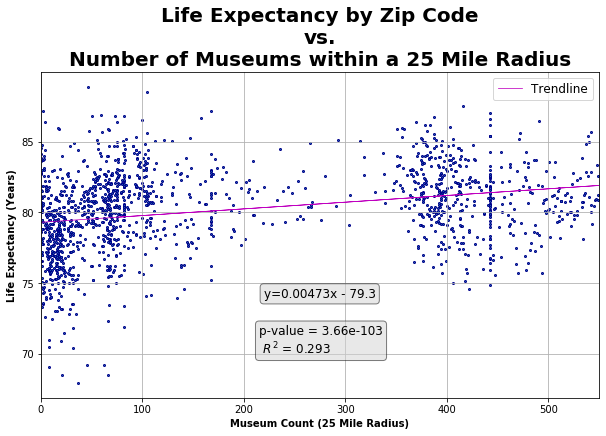

In [120]:
# Set figure size
fig, ax = plt.subplots(figsize=(10,6))

# Scatter plot of life expectancy verses number of parks, set marker size to 4
ax.scatter(life_v_search['Count'].values,life_v_search['Life Expectancy'].values,4,edgecolor='darkblue')

# Label axes, add title
ax.set_xlabel('Museum Count (25 Mile Radius)', weight='bold')
ax.set_ylabel('Life Expectancy (Years)', weight='bold')
ax.set_title('Life Expectancy by Zip Code\nvs.\nNumber of Museums within a 25 Mile Radius',size=20, weight='bold')
ax.set_xlim(0,550)
#plt.xticks(np.arange(0,100,5))
#plt.yticks(np.arange(0,1000,100))
ax.grid()


# Calculate and add trendline
z = np.polyfit(life_v_search['Count'].values, life_v_search['Life Expectancy'].values, 1)

p = np.poly1d(z)

props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

# Plot the trendline equation to graph
ax.text(330,74,"y=%.5fx - %.1f"%(z[0],abs(z[1])), ha='right',size=12, bbox=props)

# plot the p-value and correlation coefficient to graph
ax.text(215,70,f"p-value = {'{:.2e}'.format(p2_all)}\n $R^2$ = {'{:.3f}'.format(corr_coeff_all)}",size=12,bbox=props)

# Plot trendline
plb.plot(life_v_search['Count'].values, p(life_v_search['Count'].values), 'm-',linewidth=.75)

# Add legend
ax.legend(['Trendline'],fontsize=12)

# Save the figure
figure_file_path = 'images/life_expectancy_vs_museum_' + str(search_radius) + 'mi_' + d.datetime.today().strftime("%Y-%m-%d-%H%M%S") + '.png'
plt.savefig(figure_file_path,bbox_inches="tight")
plt.show()